In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from matplotlib import pyplot as plt

In [2]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [3]:
from converter_ZOE_CEOD import convert_CEOD_ZOE, keys

In [4]:
directory = "C:/Users/mohsy/University/KLM/Air France KLM/ES Data Team - 2019 Feb"
print(f'There are currently {len(os.listdir(directory))} csv files in the CEOD_GEnx/csv files directory')

There are currently 8 csv files in the CEOD_GEnx/csv files directory


In [5]:
pd.options.display.max_seq_items = 2000
for file in os.listdir(directory)[1:]:
    data_original = pd.read_pickle(directory + "/" + file)
    print(data_original.columns)
    print(data_original['flight_id'])
    break

Index(['flight_id', 'departure_yearmonth', 'row_number',
       'header__emu_level_c_as_part_number',
       'header__fadec_hardware_p_n__10_alpha_numerics',
       'header__emu_report_code', 'header__flight_number',
       'header__departure_airport_character_1_through_4',
       'header__engine_serial_number',
       'header__flight_number_character_1_through_10',
       'header__communication_system', 'header__departure_airport',
       'plane_tail', 'header__software_version',
       'header__ge_supplemental_acars_address',
       'header__destination_airport_character_1_through_4',
       'header__aircraft_id_character_1_through_9', 'header__aircraft_id',
       'header__destination_airport', 'header__emu_level_e_as_part_number',
       'header__fadec_channel_discretes', 'header__engine_serial_number1',
       'header__emu_hardware_part_number', 'header__operator_id',
       'uvl_wfqps3rcalc', 'selected_total_temperature_at_station_12_deg_c',
       'torque_motor_7_demand_current_

In [6]:
def create_regression(data, X, Y):
    # Create a polynomial regression model
    degree = 3  # Adjust the degree as needed
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(data[[X]], data[Y])
    
    predicted_values = model.predict(data[['X']])
    
    residuals = data['Y'] - predicted_values
    

In [9]:
def filter_around_moving_median(df, column_name, window_size, threshold):
    # Calculate the rolling median
    arr1 = df[column_name].rolling(window=window_size, center=True).median()

    # Calculate the absolute difference between the value and the rolling median
    arr2 = np.abs(df[column_name] - arr1)

    # Filter rows based on the difference from the rolling median
    filtered_df = df[arr2 <= threshold]

    # Drop the temporary columns used for calculations
#     filtered_df = filtered_df.drop(columns=['RollingMedian', 'DiffFromMedian'])

    return filtered_df

data_mohamed_2019_feb_1-9.pkl 0
(7, 43)
(683, 43)
(1130, 43)


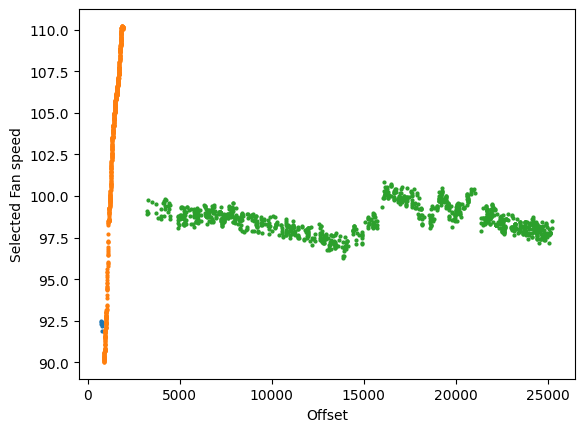

0
data_mohamed_2019_feb_1-9.pkl 1
(4, 43)
(590, 43)
(619, 43)


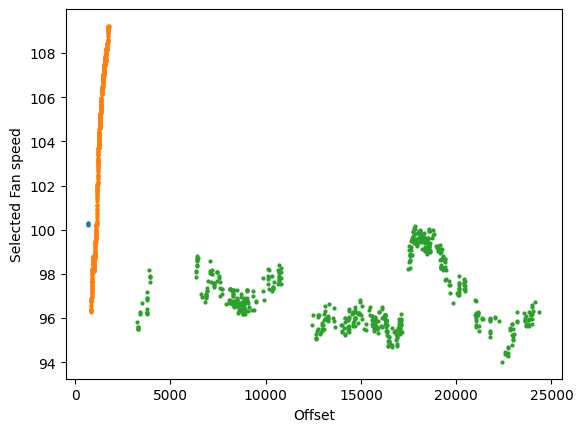

1
data_mohamed_2019_feb_1-9.pkl 2
(13, 43)
(602, 43)
(935, 43)


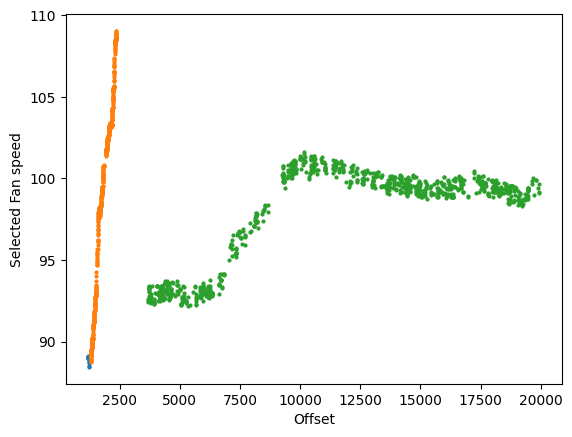

2
data_mohamed_2019_feb_1-9.pkl 3
(8, 43)
(732, 43)
(800, 43)


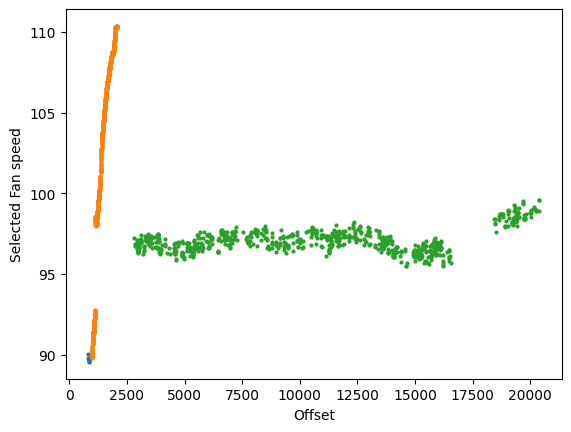

3
data_mohamed_2019_feb_10-11.pkl 0
(13, 43)
(610, 43)
(0, 43)


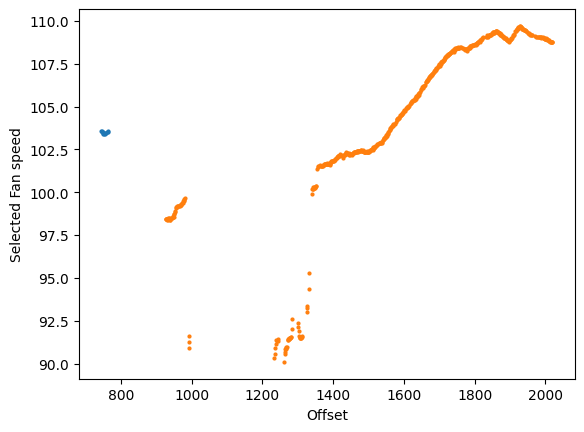

0
data_mohamed_2019_feb_10-11.pkl 1
(4, 43)
(448, 43)
(1090, 43)


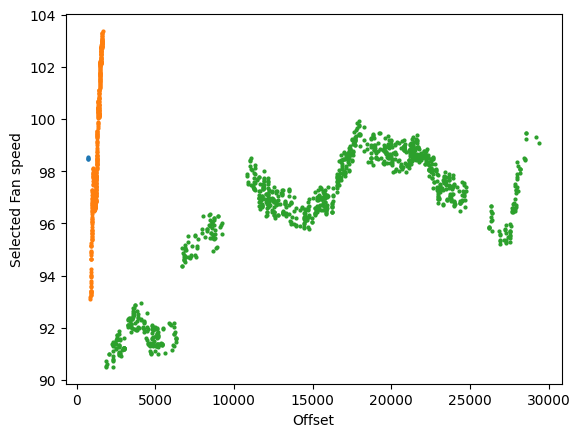

1
data_mohamed_2019_feb_10-11.pkl 2
(10, 43)
(521, 43)
(3121, 43)


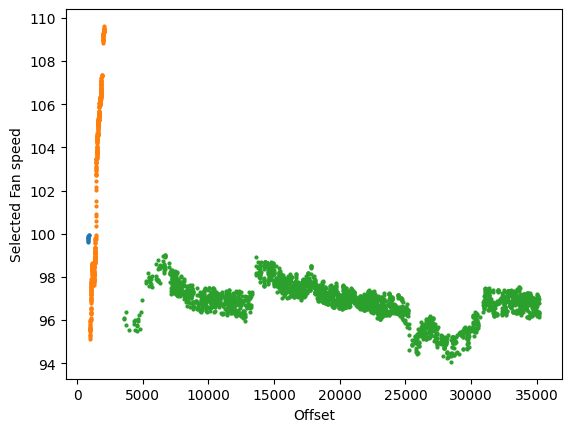

2
data_mohamed_2019_feb_10-11.pkl 3
(8, 43)
(701, 43)
(1890, 43)


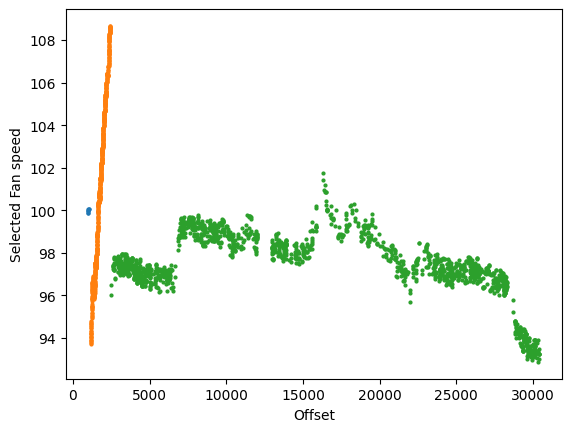

3
data_mohamed_2019_feb_12-14.pkl 0
(8, 43)
(656, 43)
(1379, 43)


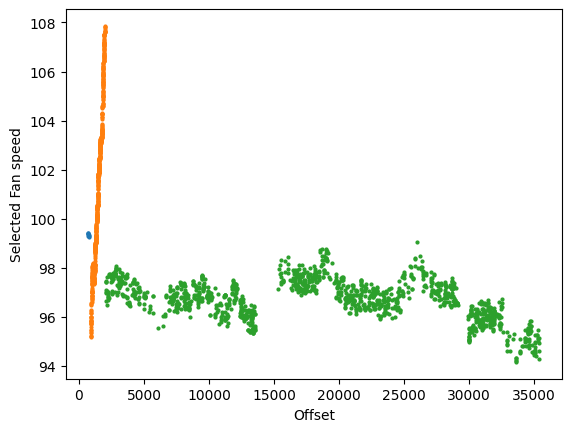

0
data_mohamed_2019_feb_12-14.pkl 1
(17, 43)
(682, 43)
(1402, 43)


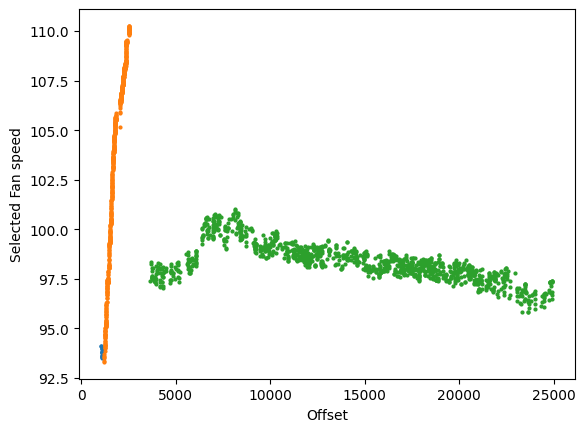

1
data_mohamed_2019_feb_12-14.pkl 2
(13, 43)
(655, 43)
(2506, 43)


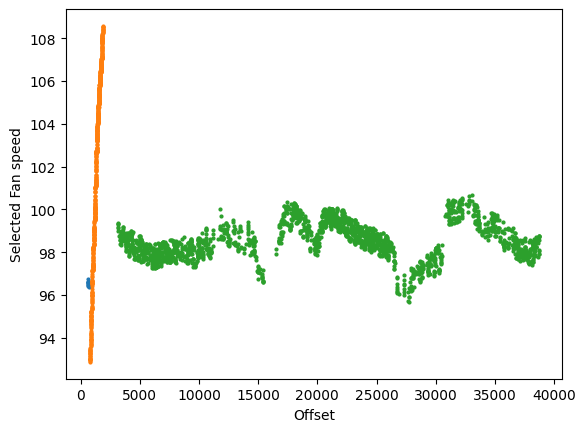

2
data_mohamed_2019_feb_12-14.pkl 3
(7, 43)
(467, 43)
(1923, 43)


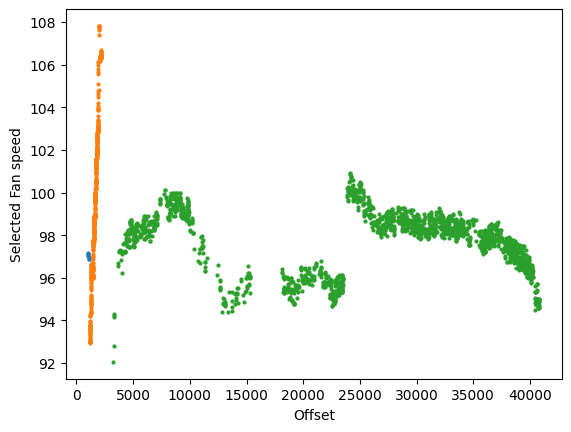

3
data_mohamed_2019_feb_12-14.pkl 4
(6, 43)
(570, 43)
(2794, 43)


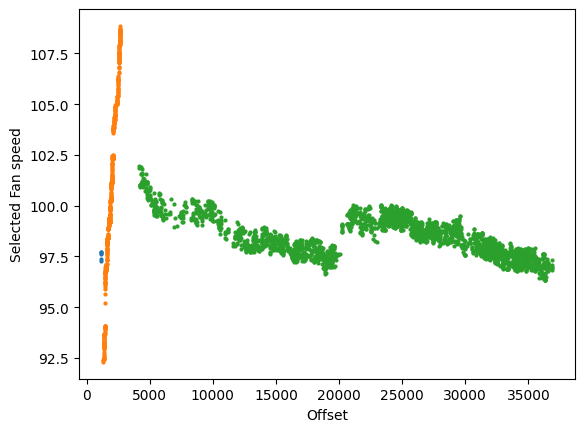

4
data_mohamed_2019_feb_15-17.pkl 0
(14, 43)
(316, 43)
(1651, 43)


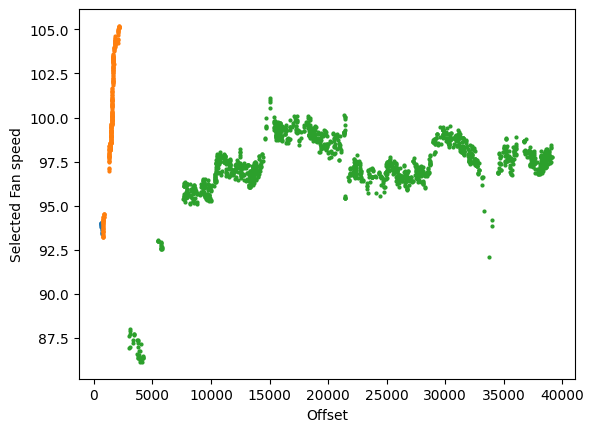

0
data_mohamed_2019_feb_15-17.pkl 1
(11, 43)
(695, 43)
(1472, 43)


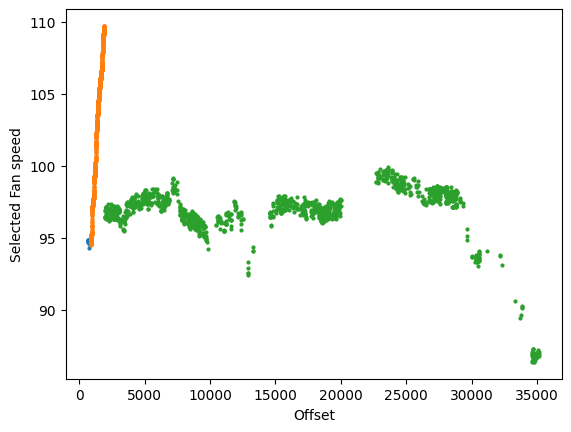

1
data_mohamed_2019_feb_15-17.pkl 2
(12, 43)
(659, 43)
(1493, 43)


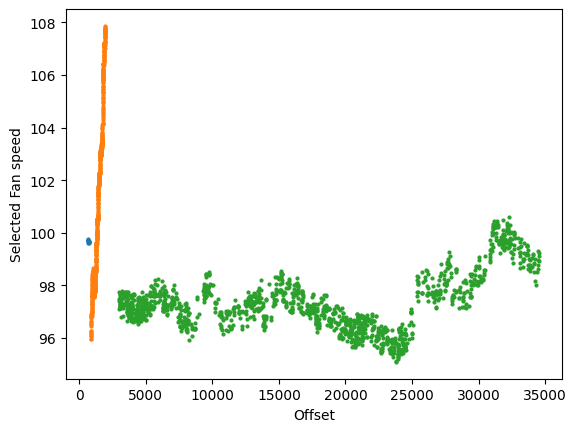

2
data_mohamed_2019_feb_15-17.pkl 3
(9, 43)
(504, 43)
(1904, 43)


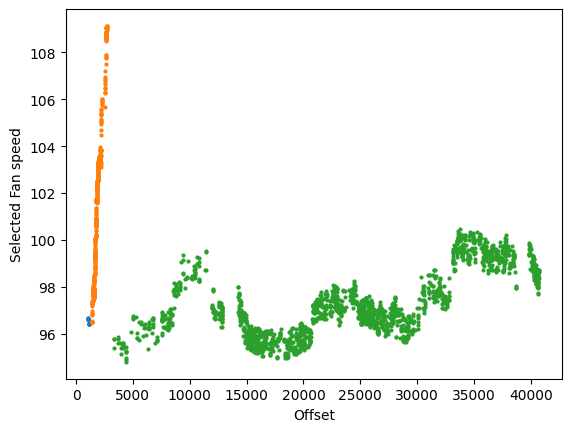

3
data_mohamed_2019_feb_15-17.pkl 4
(6, 43)
(673, 43)
(755, 43)


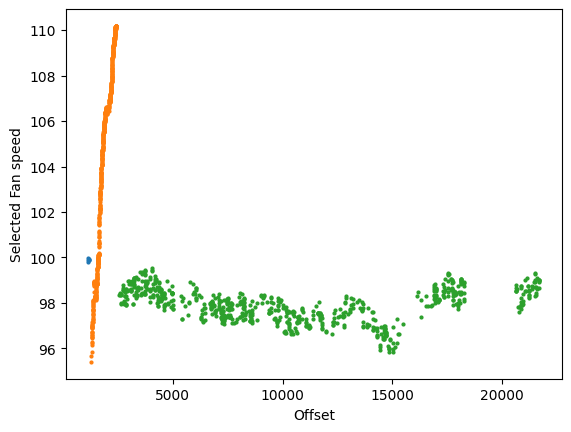

4
data_mohamed_2019_feb_18-20.pkl 0
(4, 43)
(670, 43)
(1227, 43)


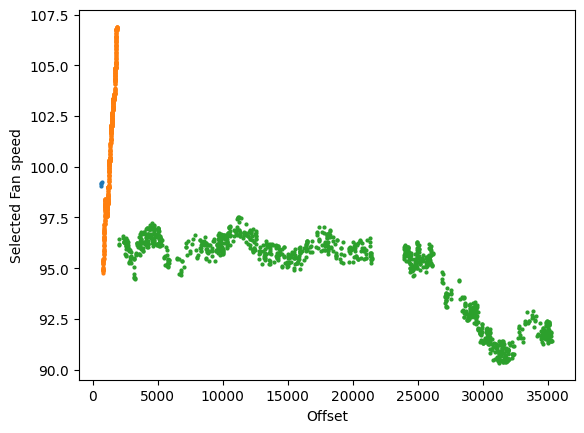

0
data_mohamed_2019_feb_18-20.pkl 1
(9, 43)
(578, 43)
(1610, 43)


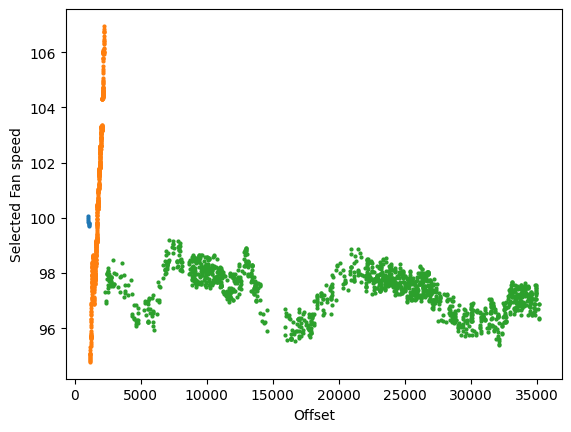

1
data_mohamed_2019_feb_18-20.pkl 2
(15, 43)
(700, 43)
(1330, 43)


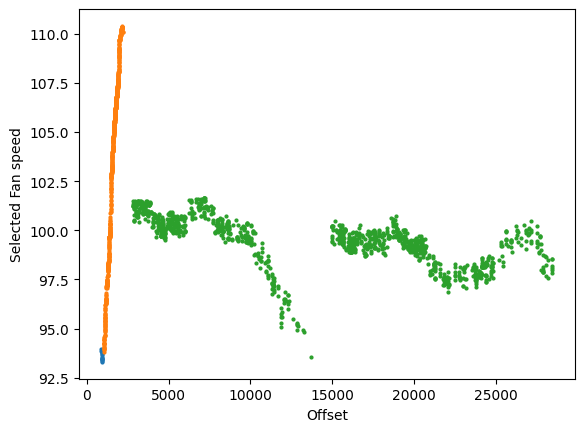

2
data_mohamed_2019_feb_18-20.pkl 3
(17, 43)
(671, 43)
(1196, 43)


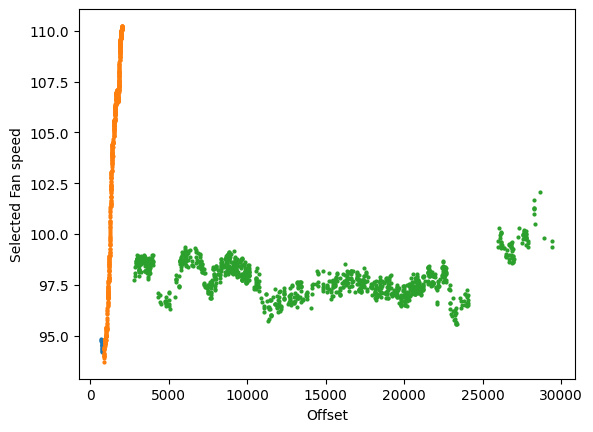

3
data_mohamed_2019_feb_18-20.pkl 4
(11, 43)
(687, 43)
(1960, 43)


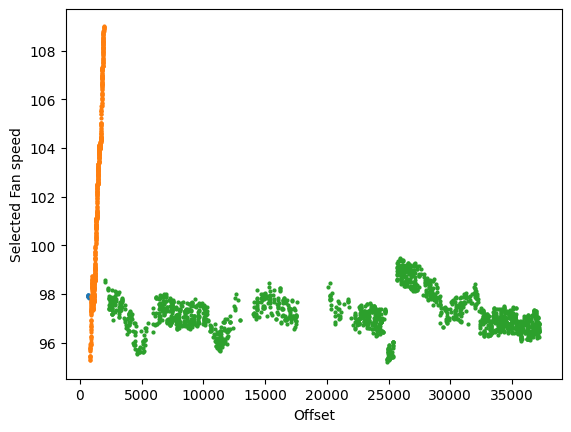

4
data_mohamed_2019_feb_18-20.pkl 5
(5, 43)
(652, 43)
(1884, 43)


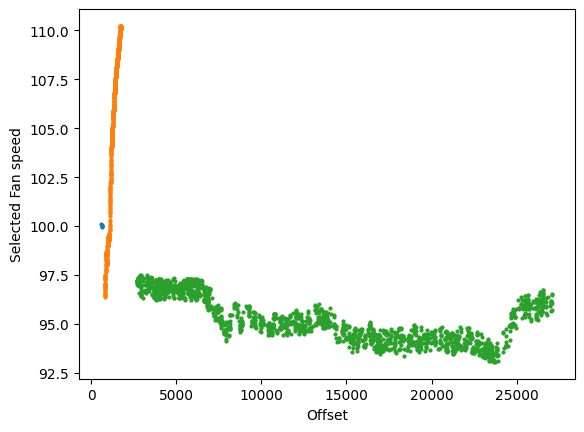

5
data_mohamed_2019_feb_21-24.pkl 0
(8, 43)
(670, 43)
(1781, 43)


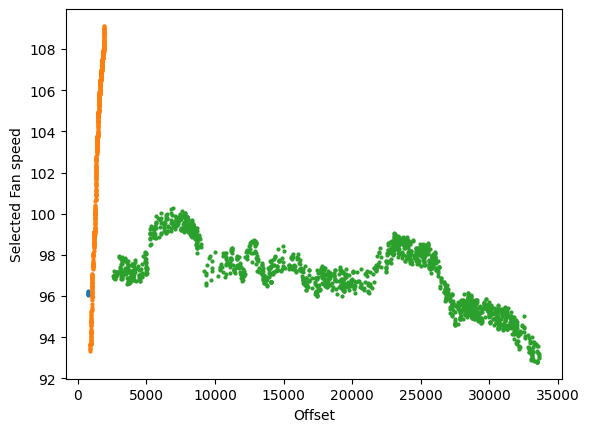

0
data_mohamed_2019_feb_21-24.pkl 1
(11, 43)
(558, 43)
(1551, 43)


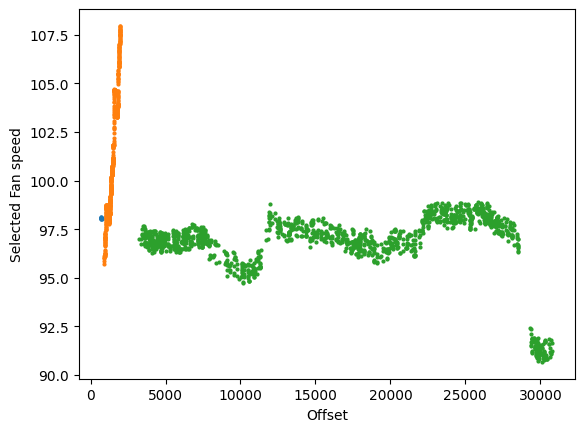

1
data_mohamed_2019_feb_25-28.pkl 0
(13, 43)
(435, 43)
(1602, 43)


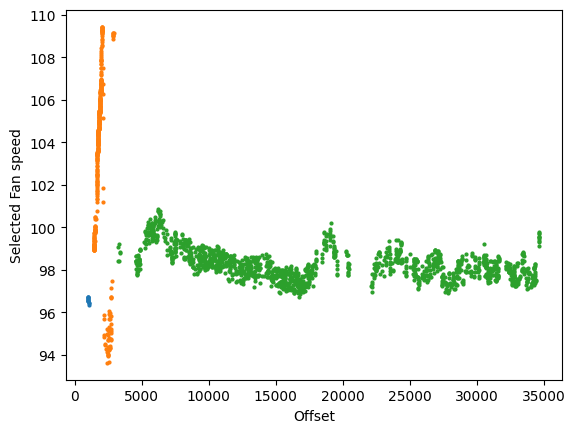

0


In [11]:
counter = 0
for file in os.listdir(directory)[1:]:
    data_original = pd.read_pickle(directory + "/" + file)
    data_original = data_original[keys]
    data_original = data_original.rename(columns=convert_CEOD_ZOE)
    
    for flight_idx, flight_ in enumerate(np.unique(data_original["flight_id"])):
        print(file, flight_idx)
        data = data_original[data_original["flight_id"] == flight_]

        dataCL = data[(data["UVL_FLIGHTPHS"] == 6)]
        dataCL = dataCL[(dataCL["Core Speed Rate of Change (%N2/SEC)"] > - 0.1)
                        & (dataCL["Core Speed Rate of Change (%N2/SEC)"] < 0.1)
                        & np.insert(np.abs(np.diff(dataCL["Altitude based on P0 (FT)"])) > 15, 0, True)
                        ]
        dataTO = data[(data["Core Speed Rate of Change (%N2/SEC)"] > - 0.1)
                      & (data["Core Speed Rate of Change (%N2/SEC)"] < 0.1)
                      & (data["UVL_FLIGHTPHS"] == 4)
                      ]
        dataCR = data[(data["Core Speed Rate of Change (%N2/SEC)"] > - 0.01)
                      & (data["Core Speed Rate of Change (%N2/SEC)"] < 0.01)
                      & (data["UVL_FLIGHTPHS"] == 7) 
#                       & np.insert(np.abs(np.diff(data["Selected Fan Speed (%)"])) > 0.5, 0, True)
                      ]
        
        dataCL = filter_around_moving_median(dataCL, "Selected Fan Speed (%)", 50, 1)
        dataCR = filter_around_moving_median(dataCR, "Selected Fan Speed (%)", 350, 0.5)
        
#         plt.scatter(dataCR["Offset"] , dataCR["Selected Mach Number (MACH)"] , s=4, label='Cruise')
#         plt.scatter(dataTO["Offset"] , dataTO["Selected Mach Number (MACH)"] , s=4, label='Take off')
#         plt.scatter(dataCL["Offset"] , dataCL["Selected Mach Number (MACH)"] , s=4, label='Climb')
#         plt.xlabel("Offset")
#         plt.ylabel("Selected Mach Number (MACH)")
#         plt.legend()
#         plt.show()
    
    
        GEnx_ODL, GEnx_OD_trueL, N1cCEODL, N1CEODL, alt_time = [], [], [], [], []

#         fig, axes = plt.subplots(2, 2, figsize=(8, 6), dpi=200)

        for i, dataI in enumerate([dataTO, dataCL, dataCR]):  #

            data = dataI
            
            g = 1.4
            isentr = 1 + (g - 1) * 0.5 * data["Selected Mach Number (MACH)"] ** 2
            TsComp = (data["Selected Total Temperature at Station 12 (DEG_C)"] + 273.15) / isentr
            PsComp = (data["Selected PT2 Pressure (PSIA)"] * 0.0689475729) / isentr ** (g / (g - 1))

            # N1c = data["Selected Fan Speed (%)"]/np.sqrt((data["Selected Total Temperature at Station 12 (DEG_C)"] + 273.15)/288)
            N1cdp = 94.96 / (np.sqrt((287.5 * 275.55) / (288.15 * 287.05)))  # old model (un-calib)
            N1cdp2 = 96.96 / (np.sqrt((288.18 * 285.6) / (288.15 * 287.05)))  # new model (calib) + martijn model
            # N1c   = 100*data["Selected Fan Speed (%)"]\
            #         / (np.sqrt((288*(data["Selected Total Temperature at Station 12 (DEG_C)"] + 273.15))/(288.15*287.05))) / N1cdp
            N1c = 100 * data["Selected Fan Speed (%)"] \
                  / (np.sqrt(
                (288 * (data["Selected Total Temperature at Station 12 (DEG_C)"] + 273.15)) / (288.15 * 287.05))) / N1cdp2

            GEnx_OD_true = np.vstack((data["Selected Fan Speed (%)"],
                                      N1c,
                                      data["Corrected Fan Speed to Station 12 (%)"],
                                      data["Selected HP Comp Inlet Total Temperature (DEG_C)"] + 273.15,
                                      data["Selected Compressor Delay Total Temperature (DEG_C)"] + 273.15,
                                      data["Selected Compressor Discharge Static Pressure (PSIA)"] * 0.0689475729,
                                      data["Selected Exhaust Gas Temperature (DEG_C)"] + 273.15,
                                      data["Selected Mass Fuel Flow (PPH)"] * 0.0001259979,
                                      data["Selected Core Speed (%)"]
                                      )).T


            GEnx_OD = np.vstack((N1c,
                                 PsComp,
                                 TsComp,
                                 data["Selected Mach Number (MACH)"],
                                 data["Total Engine Horsepower Extraction (HP)"] * 0.745699872)).T
            
            extra_var = np.vstack((data["Altitude based on P0 (FT)"], data["Offset"])).T
            
            
            
            #filtering isolation forrest
#             filtering_array = np.concatenate((GEnx_OD_true, GEnx_OD, extra_var), axis=1)
#             print("before", filtering_array.shape)
#             ## create an isolation forrest scheme
#             iso_forest = IsolationForest(contamination=0.3)  # contamination is the outlier proportion
#             iso_forest.fit(filtering_array)
#             outlier_predictions = iso_forest.predict(filtering_array)
#             filtering_array = filtering_array[outlier_predictions == 1]
#             print("after", filtering_array.shape)
                    
#             #re-slice
#             GEnx_OD_true = filtering_array[:, 0:9]
#             GEnx_OD = filtering_array[:, 9:14]
#             GEnx_OD_extra_vartrue = filtering_array[:, 14:16]
            
            N1CEOD = GEnx_OD_true[:, 0]
            N1cCEOD = GEnx_OD_true[:, 2]
            GEnx_OD_true = GEnx_OD_true[:, 3:]
            
            GEnx_ODL.append(GEnx_OD)
            GEnx_OD_trueL.append(GEnx_OD_true)
            N1cCEODL.append(N1cCEOD)
            N1CEODL.append(N1CEOD)
            alt_time.append(extra_var)
            
            print(data.shape)
            plt.scatter(extra_var[:, 1], GEnx_OD[:, 0] , s=4)

        plt.xlabel("Offset")
        plt.ylabel("Selected Fan speed")
        plt.show()
    #         plt.xlim([0, 5000])
        print(flight_idx)
#         if "CEOD_" + file.strip(".pkl") +  f"_{flight_idx}.p" == "CEOD_data_mohamed_2019_feb_1-9_2.p":
        pickle.dump([GEnx_ODL, GEnx_OD_trueL, N1cCEODL, alt_time], open("CEOD_GEnx/same_engine_flights/CEOD_nomedian filter_" + file.strip(".pkl") +
                                                                            f"_{flight_idx}.p", "wb"))